# RTED-TDS Co-Sim

This notebook is used to implement the Co-Simulation of Real Time Economic Dispatch (RTED) and Time-Domain Simulation (TDS).
In the RTED, SFR is considered. In the TDS, AGC is implemented.

RTED is seperated into two DCOPF and ACOPF: 1) DCOPF with SFR is solved in gurobipy, which is packaged into the class ``rted`` in the file ``rted.py``. 2) ACOPF is solved in pandapower.

Class ``rted`` has attributes ``rted`` and ``dcopf``. The two attributes are the RTED model and standard DCOPF model.
The two model can be built by methods ``build_rted()`` and ``build_dcopf()``, respectively. The results can be accessed by method ``get_res()``, after successfully solved the ``rted`` or ``dcopf``.

Table of contents:
- Import case: import ADNES case
- Load synthetic: build load curve as a scalar
- Setup ``ssp`` and ``ssd``
- Prepare: define some functions
- Define param: define RTED loop parameters
- Loop: Co-Sim loop

List of major vars:

- ``ssa`` ANDES system
- ``ssp`` pandapower net
- ``ssd`` DCOPF instance

Things need to be done when switching to other cases:
- Assign generator cost data. The rows of gen_cost array should be the same with the length of ``ssp.gen``
  including those uncontrollable ones, so the DCOPF model can build correctly.
- Define generator controllability of ``ssp``, all generators are controllable by default
- Define power system data: SFR cost, ramp limit (5-min-based)
- Define generator type in ``ssd``, default as type I. For type I generator, generator limtis have impact on both generation and SFR capacity. For yype II generator, SFR capacity is determined by param ``pru_max`` and ``prd_max``

Environment requirements:
- ANDES (1.6.3+)
- pandapower (2.7.0 is tested to be function correctly)
- gurobipy
- pandas, amtplotlib, scipy

## Import case

In [1]:
import andes
import numpy as np
from andes.interop.pandapower import to_pandapower, make_link_table, runopp_map
from andes.interop.pandapower import add_gencost, build_group_table
andes.config_logger(stream_level=20)

import pandas as pd
import pandapower as pp
from math import ceil, floor

import os

import matplotlib.pyplot as plt

import scipy.stats as stat

from rted import rted

Package version

In [2]:
print(andes.__version__)
print(pp.__version__)

1.6.3.post135.dev0+g985fcacb
2.7.0


Import ADNES case

In [3]:
# ss0 is used for PP conversion
dir_path = os.path.abspath('..')
case_path = '/case/ieee39_ev2.xlsx'
case = dir_path + case_path
ssa = andes.load(case,
                 setup=True,
                 no_output=True,
                 default_config=False)

Working directory: "/home/jwang175/andes/jwang/notes"
> Loaded config from file "/home/jwang175/.andes/andes.rc"
> Loaded generated Python code in "/home/jwang175/.andes/pycode".
Parsing input file "/home/jwang175/andes/jwang/case/ieee39_ev2.xlsx"...
Input file parsed in 0.2001 seconds.
ACEc <1> added BusFreq <BusFreq_11> linked to bus <1>
System internal structure set up in 0.0443 seconds.


Set load as constant load.

In [4]:
ssa.PQ.config.p2p = 1
ssa.PQ.config.q2q = 1
ssa.PQ.config.p2z = 0
ssa.PQ.config.q2z = 0
ssa.PQ.pq2z = 0

Turn on ``numba`` can accelerate TDS.

In [5]:
ssa.config.numba

1

## Load synthetic

Create load data ``d_syn``, which is a ``DataFrame`` that have three columns: ``time``, ``s10``, ``h10``. ``time`` is by seconds, ``s10`` is scalar load.

ANDES total load is: 58.564 p.u.


Text(0.5, 0, 'Time [s]')

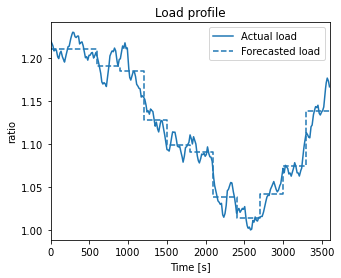

In [6]:
# --- get ANDES load ---
ptotal = ssa.PQ.as_df()['p0'].sum()
print('ANDES total load is:',ptotal.round(4),'p.u.')

# --- scale d_syn ---
ddata_path = '/case/d_syn2.csv'
ddata = dir_path + ddata_path
d_syn = pd.read_csv(ddata)

ratio = 100
# The equation is tuned for ieee39
# original: (d_syn['h10'] - d_syn['h10'].mean()) / d_syn['h10'].var() * ratio + 1
d_syn['s10'] = 0.5*(d_syn['h10'] - d_syn['h10'].min()) / d_syn['h10'].var() * ratio + 1

# calculate expected load
step = 300
d_exp = d_syn.groupby(d_syn.index // step).mean().copy()
d_exp['time'] = range(0,3600,300)

fig_load, ax_load = plt.subplots(figsize=(5, 4))
ax_load.plot(d_syn['time'], d_syn['s10'], color='tab:blue', linestyle='-')
ystep = list(d_exp['s10'])
ystep.insert(0, d_exp['s10'].iloc[0])
ax_load.step(range(0,3900,300), ystep, color='tab:blue', linestyle='--')
ax_load.set_xlim([0, 3600])
ax_load.legend(['Actual load', 'Forecasted load'])
ax_load.set_title('Load profile')
ax_load.set_ylabel('ratio')
ax_load.set_xlabel('Time [s]')

## Setup ``ssp`` and ``ssd``

Convert ``ssa`` to pandapower net ``ssp``, add generator cost

The input cost array follow the matpower/pypower format, now only poly_cost is supported

In [7]:
# --- quadratic cost ---
# gen_cost = np.array([
#     [2, 0, 0, 3, 0.01, 0.29, 0.2],
#     [2, 0, 0, 3, 0.01, 0.24, 0.2],
#     [2, 0, 0, 3, 0.01, 0.26, 0.2],
#     [2, 0, 0, 3, 0.01, 0.31, 0.2],
#     [2, 0, 0, 3, 0.01, 0.32, 0.2],
#     [2, 0, 0, 3, 0.01, 0.33, 0.2],
#     [2, 0, 0, 3, 0.01, 0.34, 0.2],
#     [2, 0, 0, 3, 0.01, 0.21, 0.2],
#     [2, 0, 0, 3, 0.01, 0.35, 0.2],
#     [2, 0, 0, 3, 0.00, 0.00, 0.0],    # EV
#     [2, 0, 0, 3, 0.01, 0.40, 0.2],    # Slack
# ])

In [8]:
# --- conversion ---
ssp = to_pandapower(ssa)

# add gen cost
gen_cost = np.array([
    [2, 0, 0, 3, 0.0, 0.29, 0],
    [2, 0, 0, 3, 0.0, 0.24, 0],
    [2, 0, 0, 3, 0.0, 0.26, 0],
    [2, 0, 0, 3, 0.0, 0.31, 0],
    [2, 0, 0, 3, 0.0, 0.32, 0],
    [2, 0, 0, 3, 0.0, 0.33, 0],
    [2, 0, 0, 3, 0.0, 0.34, 0],
    [2, 0, 0, 3, 0.0, 0.21, 0],
    [2, 0, 0, 3, 0.0, 0.35, 0],
    [2, 0, 0, 3, 0.0, 0.00, 0],    # EV
    [2, 0, 0, 3, 0.0, 0.40, 0],    # Slack
])

add_gencost(ssp, gen_cost)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.1972 seconds.
0: |F(x)| = 7.561234474
1: |F(x)| = 2.916785548
2: |F(x)| = 0.1314169328
3: |F(x)| = 0.0003491192315
4: |F(x)| = 4.240441775e-09
Converged in 5 iterations in 0.0103 seconds.
Power flow results are consistent. Conversion is successful.


True

**NOTE**: Alter the controllability of generator by modifying ``ssp.gen.controllable``

In [9]:
# set EV generator as uncontrollable
ssp.gen.controllable.iloc[9] = False

In [10]:
ssp.gen

,name,bus,p_mw,vm_pu,sn_mva,min_q_mvar,max_q_mvar,scaling,slack,in_service,type,controllable,min_p_mw,max_p_mw,power_station_trafo
0,PV_1,29,436.086385,1.035534,100.0,-58.084,153.180,1.0,False,True,None,True,10.0,1200.0,NaN
1,PV_2,30,645.999998,1.013246,100.0,-122.665,429.804,1.0,False,True,None,True,10.0,800.0,NaN
2,PV_3,31,724.999998,1.020528,100.0,-180.218,446.722,1.0,False,True,None,True,10.0,1000.0,NaN
3,PV_4,32,651.999998,1.013430,100.0,-213.780,548.208,1.0,False,True,None,True,10.0,800.0,NaN
4,PV_5,33,520.000000,1.019109,100.0,-188.028,611.495,1.0,False,True,None,True,10.0,800.0,NaN
5,PV_6,34,690.000000,1.060000,100.0,-234.972,593.788,1.0,False,True,None,True,10.0,700.0,NaN
6,PV_7,35,590.000000,1.060000,100.0,-249.132,568.372,1.0,False,True,None,True,10.0,700.0,NaN
7,PV_8,36,330.000000,1.013996,100.0,-216.122,443.468,1.0,False,True,None,True,10.0,700.0,NaN
8,PV_9,37,780.000000,1.052803,100.0,-356.889,834.775,1.0,False,True,None,True,10.0,1000.0,NaN
9,PV_10,37,-50.000000,1.052803,100.0,0.000,0.000,1.0,False,True,None,False,-60.0,70.0,NaN


Build DCOPF instance ``ssd``

In [11]:
ssd = rted(ssp)

GSF is consistent.


Alter the EV generator type in ``ssd``

In [12]:
ssd.def_typeII(['gen10'])

True

In [13]:
ssd.gendata

,gen_pp,cp1,cp2,cp0,bus,ctrl,p0,pmax,pmin,type,c_ru,c_rd,rampu,rampd,p_pre,pru_max,prd_max
name,,,,,,,,,,,,,,,,,
gen1,PV_1,0.29,0.0,0.0,29,1,4.360864,12.0,0.1,I,0,0,10,10,0,0,0
gen2,PV_2,0.24,0.0,0.0,30,1,6.460000,8.0,0.1,I,0,0,10,10,0,0,0
gen3,PV_3,0.26,0.0,0.0,31,1,7.250000,10.0,0.1,I,0,0,10,10,0,0,0
gen4,PV_4,0.31,0.0,0.0,32,1,6.520000,8.0,0.1,I,0,0,10,10,0,0,0
gen5,PV_5,0.32,0.0,0.0,33,1,5.200000,8.0,0.1,I,0,0,10,10,0,0,0
gen6,PV_6,0.33,0.0,0.0,34,1,6.900000,7.0,0.1,I,0,0,10,10,0,0,0
gen7,PV_7,0.34,0.0,0.0,35,1,5.900000,7.0,0.1,I,0,0,10,10,0,0,0
gen8,PV_8,0.21,0.0,0.0,36,1,3.300000,7.0,0.1,I,0,0,10,10,0,0,0
gen9,PV_9,0.35,0.0,0.0,37,1,7.800000,10.0,0.1,I,0,0,10,10,0,0,0


Benchmark Standard DCOPF of ``ssd`` with ``ssp``

In [14]:
ssp.gen

,name,bus,p_mw,vm_pu,sn_mva,min_q_mvar,max_q_mvar,scaling,slack,in_service,type,controllable,min_p_mw,max_p_mw,power_station_trafo
0,PV_1,29,436.086385,1.035534,100.0,-58.084,153.180,1.0,False,True,None,True,10.0,1200.0,NaN
1,PV_2,30,645.999998,1.013246,100.0,-122.665,429.804,1.0,False,True,None,True,10.0,800.0,NaN
2,PV_3,31,724.999998,1.020528,100.0,-180.218,446.722,1.0,False,True,None,True,10.0,1000.0,NaN
3,PV_4,32,651.999998,1.013430,100.0,-213.780,548.208,1.0,False,True,None,True,10.0,800.0,NaN
4,PV_5,33,520.000000,1.019109,100.0,-188.028,611.495,1.0,False,True,None,True,10.0,800.0,NaN
5,PV_6,34,690.000000,1.060000,100.0,-234.972,593.788,1.0,False,True,None,True,10.0,700.0,NaN
6,PV_7,35,590.000000,1.060000,100.0,-249.132,568.372,1.0,False,True,None,True,10.0,700.0,NaN
7,PV_8,36,330.000000,1.013996,100.0,-216.122,443.468,1.0,False,True,None,True,10.0,700.0,NaN
8,PV_9,37,780.000000,1.052803,100.0,-356.889,834.775,1.0,False,True,None,True,10.0,1000.0,NaN
9,PV_10,37,-50.000000,1.052803,100.0,0.000,0.000,1.0,False,True,None,False,-60.0,70.0,NaN


In [15]:
ssd.def_var(ptotal=ssp.load.p_mw.sum() / ssp.sn_mva,
            dpd_u=0.0, dpd_d=0.0, p_pre=ssd.gendata.p0.tolist())
ssd.build_sdc()
ssd.dcopf.optimize()

pp.rundcopp(ssp)
ppres = ssp.res_gen.copy()
ppres['p_mw(GB)'] = ssp.sn_mva * ssd.get_res('dcopf')['p_sch'].values
print(f"pp cost={ssp.res_cost}")
ppres

pru_max length does not match Type II generator numbers!
prd_max length does not match Type II generator numbers!


Restricted license - for non-production use only - expires 2023-10-25
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 139 rows, 33 columns and 657 nonzeros
Model fingerprint: 0xedeaaecb
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [2e-01, 4e-01]
  Bounds range     [1e-01, 2e+01]
  RHS range        [1e-01, 6e+01]
Presolve removed 135 rows and 23 columns
Presolve time: 0.01s
Presolved: 4 rows, 10 columns, 37 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3049440e+01   5.628765e+01   0.000000e+00      0s
       1    1.6724120e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.672412000e+01


dcopf cost (p.u.): Total=16.724, GEN=16.724, SFR=0.0


pp cost=1672.4120008739646


,p_mw,q_mvar,va_degree,vm_pu,p_mw(GB)
0,1199.999998,NaN,17.796874,1.0,1200.0
1,799.999999,NaN,10.915628,1.0,800.0
2,999.999999,NaN,16.465326,1.0,1000.0
3,799.999995,NaN,12.008826,1.0,800.0
4,799.999990,NaN,14.375004,1.0,800.0
5,286.400005,NaN,-3.609774,1.0,286.4
6,10.000010,NaN,-6.967094,1.0,10.0
7,699.999999,NaN,13.597839,1.0,700.0
8,10.000005,NaN,-17.388174,1.0,10.0
9,-50.000000,NaN,-17.388174,1.0,-50.0


Test RTED model of ``ssd``

In [16]:
# def. parameters
ssd.def_ps(c_ru=[], c_rd=[], rampu=[], rampd=[])
# # def. variables
ssd.def_var(ptotal=ssp.load.p_mw.sum() / ssp.sn_mva,
            dpd_u=0.0, dpd_d=0.0, p_pre=[],
            gen=['gen6'], pru_max=[0], prd_max=[0])

ssd.build_rted()

ssd.rted.optimize()

ssd.get_res('rted')

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 635 nonzeros
Model fingerprint: 0xc49ec3af
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [2e-01, 4e-01]
  Bounds range     [1e-01, 2e+01]
  RHS range        [1e-01, 6e+01]
Presolve removed 113 rows and 23 columns
Presolve time: 0.00s
Presolved: 4 rows, 10 columns, 37 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3049440e+01   5.628765e+01   0.000000e+00      0s
       1    1.6724120e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.672412000e+01


rted cost (p.u.): Total=16.724, GEN=16.724, SFR=0.0


,gen_pp,p_sch,pru,prd,bu,bd
name,,,,,,
gen1,PV_1,12.000,0.0,0.0,0.0,0.0
gen2,PV_2,8.000,0.0,0.0,0.0,0.0
gen3,PV_3,10.000,0.0,0.0,0.0,0.0
gen4,PV_4,8.000,0.0,0.0,0.0,0.0
gen5,PV_5,8.000,0.0,0.0,0.0,0.0
gen6,PV_6,2.864,0.0,0.0,0.0,0.0
gen7,PV_7,0.100,0.0,0.0,0.0,0.0
gen8,PV_8,7.000,0.0,0.0,0.0,0.0
gen9,PV_9,0.100,0.0,0.0,0.0,0.0


## Prepare

### Make link table

In [17]:
# --- link_table ---
ssa_key = make_link_table(ssa)

# --- add controllable in the link table ---
ssa_bus = ssa.Bus.as_df().reset_index().rename(columns={'uid':'bus_pp', 'idx':'bus_idx'})
ssp_gen = ssp.gen.reset_index().rename(columns={'index':'gen_pp', 'name':'stg_idx', 'controllable':'ctrl'})
ssa_key2 = pd.merge(left=ssa_key,
                    right=ssp_gen[['stg_idx', 'gen_pp', 'ctrl']],
                    on='stg_idx', how='left')

# --- device idx ---
ssa_dg_idx = ssa_key2.dg_idx.dropna().tolist()
ssa_syg_idx = ssa_key2.syg_idx.dropna().tolist()
ssa_gov_idx = ssa_key2.gov_idx.dropna().tolist()
ssa_stg_idx = ssa_key2.stg_idx.dropna().tolist()

# --- online and controllable device idx ---
ctrl_cond = ssa_key2.ctrl * ssa_key2.stg_u.astype(bool)
ssa_dg_idx_ctrl = ssa_key2.dg_idx[ctrl_cond].dropna().tolist()
ssa_syg_idx_ctrl = ssa_key2.syg_idx[ctrl_cond].dropna().tolist()
ssa_gov_idx_ctrl = ssa_key2.gov_idx[ctrl_cond].dropna().tolist()
ssa_stg_idx_ctrl = ssa_key2.stg_idx[ctrl_cond].dropna().tolist()

# fill NaN with False
ssa_key2.fillna(value=False, inplace=True)

ssa_key2

/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


,stg_name,stg_u,stg_idx,bus_idx,dg_idx,syg_idx,exc_idx,gov_idx,bus_name,gammap,gammaq,gen_pp,ctrl
0,PV_1,1.0,PV_1,30,False,GENROU_1,IEEEX1_1,TGOV1_1,GEN30,1.0,1.0,0,True
1,PV_2,1.0,PV_2,31,False,GENROU_2,IEEEX1_2,TGOV1_2,GEN31,1.0,1.0,1,True
2,PV_3,1.0,PV_3,32,False,GENROU_3,IEEEX1_3,TGOV1_3,GEN32,1.0,1.0,2,True
3,PV_4,1.0,PV_4,33,False,GENROU_4,IEEEX1_4,TGOV1_4,GEN33,1.0,1.0,3,True
4,PV_5,1.0,PV_5,34,False,GENROU_5,IEEEX1_5,TGOV1_5,GEN34,1.0,1.0,4,True
5,PV_6,1.0,PV_6,35,False,GENROU_6,IEEEX1_6,TGOV1_6,GEN35,1.0,1.0,5,True
6,PV_7,1.0,PV_7,36,False,GENROU_7,IEEEX1_7,TGOV1_7,GEN36,1.0,1.0,6,True
7,PV_8,1.0,PV_8,37,False,GENROU_8,IEEEX1_8,TGOV1_8,GEN37,1.0,1.0,7,True
8,PV_9,1.0,PV_9,38,False,GENROU_9,IEEEX1_9,TGOV1_9,GEN38,1.0,1.0,8,True
9,Slack_10,1.0,Slack_10,39,False,GENROU_10,IEEEX1_10,TGOV1_10,GEN39,1.0,1.0,10,True


### Define functions used in loop

In [18]:
# --- def functions ---
def get_pe(ssa, syg_idx, dg_idx, ssa_key2):
    """Get the active power (SynGen/DG) after TDS, a DataFrame"""
    # SynGen
    pe_syg = ssa.SynGen.get(src='Pe', idx=syg_idx, attr='v')
    # DG
    Ip_dg = ssa.DG.get(src='Ipout_y', idx=dg_idx, attr='v')
    v_dg = ssa.DG.get(src='v', idx=dg_idx, attr='v')
    pe_dg = Ip_dg*v_dg
    # out
    pe = pd.DataFrame()
    pe['idx'] = syg_idx + dg_idx
    pe['pe'] = np.concatenate((pe_syg, pe_dg))
    ldf = pd.merge(left=ssa_key2.rename(columns={'dg_idx':'idx'}),
         right=pe, how='right', on='idx')
    rdf = pd.merge(left=ssa_key2.rename(columns={'syg_idx':'idx'}),
             right=pe, how='right', on='idx')
    pe['stg_idx'] = ldf['stg_idx'].fillna('') + rdf['stg_idx'].fillna('')
    return pe

def dp_calc(d_syn, idx_ed, intv_ed, ssa_p0_sum):
    """Calc SFR requirements ``dpd_u``and ``dpd_d``, and load forecasted value"""
    load = d_syn['s10'].iloc[idx_ed*intv_ed:(idx_ed*intv_ed + intv_ed)]
    load_exp = ssa_p0_sum * load.mean()
    # TODO: check if the estimation is reasonable
    load_ci = stat.t.interval(alpha=0.95, df=len(load)-1, loc=np.mean(load), scale=stat.sem(load))
    load_d = abs(ssa_p0_sum * (load_ci[0] - load_exp))
    load_u = abs(ssa_p0_sum * (load_ci[1] - load_exp))
    return load_u, load_d, load_exp

## Define param

In [19]:
# --- constants ---
t_total = 3600    # 3600s

intv_ed = 300  # RTED interval, 300s
intv_agc = 4    # AGC interval, 4s
intv_pq = 1     # PQ interval, 1s; alter load and AGC
intv_step = 100 # step change interval; smooth the setpoitns

n_ed = int(t_total/intv_ed)
n_agc = int(intv_ed/intv_agc)
n_pq = int(intv_agc/intv_pq)
n_step = floor(intv_step/intv_agc)

# --- vars ---
# AGC table
agc_table = ssp.gen[['name']].rename(columns={'name':'stg_idx'})
agc_table['paux'] = 0
agc_res = agc_table[['stg_idx']].copy()

# ACE vars
ACE_integral = 0
ACE_raw = 0
Kp = 0.05
Ki = 0.001
ace_res = pd.DataFrame()

# initial load
ssa_p0 = ssa.PQ.p0.v.copy()
ssa_q0 = ssa.PQ.q0.v.copy()
ssa_pq_idx = ssa.PQ.idx.v
ssa_p0_sum = ssa_p0.sum()

## Loop

In the loop, there are mainly X parts:

- interval RTED: run DCOPF (``ssd.mdl``), run ACOPF(``ssp``), 

- interval AGC: do AGC, do dispatch with smooth setpoints

- interval PQ: alter load, run TDS(``ssa.TDS``)

Notes:

- The setpoints for DG are coded but not verified yet.

- After the development of ANDES control room, the dispatch and AGC part can be refactored.

- interface variables: ``DG.pmx``: DPV profile, ``DG.pref0``: setpoints, ``DG.pext0``: AGC

- ACOPF in pandapower considered generator limtis of ramping and SFR reserve

In [20]:
# Reserve some capacity to avoid TDS crush
ssp.gen.max_p_mw = ssp.gen.max_p_mw * 0.8

# store original generator data
ssp_gen0 = ssp.gen.copy()

for end_time in range(t_total): # t_total
    # --- interval RTED ---
    if end_time % intv_ed == 0:
        idx_ed = end_time // intv_ed
        # --- Load update ---
        du, dd, load_exp = dp_calc(d_syn, idx_ed, intv_ed, ssa_p0_sum)
        ssp.load['p_mw'] = ssa_p0 * load_exp * ssp.sn_mva
        ssp.load['q_mvar'] = ssa_q0 * load_exp * ssp.sn_mva

        # --- RTED, update gen limits after SFR ---
        ssd = rted(ssp)
        if end_time > 0:
            # TODO: INPUT ramp limits data
            rampu = [100] * ssd.gendata.shape[0]
            rampd = [100] * ssd.gendata.shape[0]
            # get pe from TDS and sort
            pe_tds = get_pe(ssa, ssa_syg_idx, ssa_dg_idx, ssa_key2)
            pe_tds = pe_tds.merge(ssd.gendata[['gen_pp']].rename(columns={'gen_pp': 'stg_idx'}),
                                 on='stg_idx', how='right').groupby('stg_idx', as_index=False).sum()
            p_pre = pe_tds['pe'].tolist()
        else:
            rampu = [100] * ssd.gendata.shape[0]
            rampd = [100] * ssd.gendata.shape[0]
            # DCOPF results as the initial previous setpoints
            p_pre = list(ssp.res_gen.p_mw / ssp.sn_mva)

        # TODO: INPUT cost and ramp, ramp should be p.u.
        ssd.def_ps(c_ru=[], c_rd=[], rampu=rampu, rampd=rampd)

        # def sfr requirements and ev sfr limtis (p.u.)
        # TODO: Integrate EV; EV limits FROM EV; now set 0 to disable EV SFR
        ssd.def_var(ptotal=ssa_p0_sum * load_exp,
                    dpd_u=du, dpd_d=dd, p_pre=p_pre,
                    gen=['gen5'], pru_max=[0], prd_max=[0])

        # build and solve the RTED-DC
        ssd.build_rted()
        res = ssd.rted.optimize()

        dcres = ssd.get_res('rted')  # get RTED-DC resutls
        # TODO: Integrate EV; send SFR back to EV

        # Reserve SFR and ramp from Generator limits in ``ssp``
        ssp_gen = pd.merge(left=ssp.gen.rename(columns={'name':'stg_idx'}),
                           right=dcres.rename(columns={'gen_pp':'stg_idx'}),
                           on='stg_idx', how='left')
        # SFR limits
        ssp_gen['max_sfr'] = ssp_gen.max_p_mw - ssp_gen.pru * ssp.sn_mva
        ssp_gen['min_sfr'] = ssp_gen.min_p_mw + ssp_gen.prd * ssp.sn_mva
        # ramp limits
        ssp_gen['max_ramp'] = ssp.sn_mva * (np.array(p_pre) + np.array(rampu))
        ssp_gen['min_ramp'] = ssp.sn_mva * (np.array(p_pre) - np.array(rampd))
        # alter generator limits
        ssp.gen.max_p_mw = ssp_gen[['max_sfr','max_ramp']].min(axis=1)
        ssp.gen.min_p_mw = ssp_gen[['min_sfr','min_ramp']].max(axis=1)

        # --- ACOPF, update setpoints ---
        # store setpoints
        if end_time > 0:
            p0 = ssp_res['p'].values  # store setpoints
        else:
            p0 = [0] * ssa_key2.shape[0]

        # run ACOPF
        ssp_res = runopp_map(ssp, ssa_key)  # ACOPF resutls
        ssp_res['p0'] = p0                  # last setpoints
        ssp_res.fillna(False, inplace=True) # Fill NA wil False

        # reset Generator limtis
        ssp.gen.max_p_mw = ssp_gen0.max_p_mw
        ssp.gen.min_p_mw = ssp_gen0.min_p_mw

    # --- interval AGC ---
    ace_gain = 1
    if end_time % intv_agc == 0:
        idx_agc = end_time // intv_agc - idx_ed * n_agc
        # --- AGC allocation, with a power cap ---
        ACE_input = min(ACE_raw, dcres.pru.sum())
        if ACE_raw >= 0:
            ACE_input = min(ACE_raw, dcres.pru.sum())
            agc_table['paux'] = ACE_input * ace_gain * dcres.bu.values
        else:
            ACE_input = max(ACE_raw, -1 * dcres.prd.sum())
            agc_table['paux'] = ACE_input * ace_gain * dcres.bd.values
        agc_res[f'{end_time}'] = agc_table['paux']
        ace_res = ace_res.append({'time':end_time,
                                  'ace':ACE_raw, 'up':dcres.pru.sum(),
                                  'dn':-1*dcres.prd.sum(), 'in':ACE_input},
                                  ignore_index=True)
       
        # --- Do AGC ---
        # a.SynGen
        agc_syg = pd.merge(left=agc_table,
                           right=ssa_key2,
                           on='stg_idx', how='right')
        agc_syg.paux2 = agc_syg.paux * agc_syg.gammap
        cond_gov = agc_syg.ctrl * agc_syg.gov_idx.astype(bool)
        agc_gov = agc_syg.gov_idx[cond_gov].tolist()
        ssa.TurbineGov.set(src='paux0', idx=agc_gov, attr='v',
                           value=agc_syg.paux2.values)
        # b.DG
        agc_dg = pd.merge(left=agc_table,
                          right=ssa_key2,
                          on='stg_idx', how='right')
        agc_dg.paux2 = agc_dg.paux * agc_dg.gammap
        cond_dg = agc_dg.ctrl * agc_dg.dg_idx.astype(bool)
        agc_dg_idx = agc_dg.dg_idx[cond_dg].tolist()
        ssa.DG.set(src='pext0', idx=agc_dg_idx, attr='v',
                           value=agc_dg.paux2.values)
        
        # --- smooth setpoints ---
        if idx_ed == 0:
            ssp_res['pref'] = ssp_res['p']
        else:
            idx_step = min((end_time - idx_ed * intv_ed) // intv_agc + 1, n_step)
            copy = ssp_res.merge(right=pe_tds[['pe', 'stg_idx']], on='stg_idx', how='left')
            ssp_res['pe_tds'] = copy.pe
            ssp_res['pref'] = ssp_res.pe_tds + (ssp_res.p - ssp_res.pe_tds) / n_step * idx_step
        # update SynGen setpoints
        cond_gov = ssp_res.controllable * ssp_res.gov_idx.astype(bool)
        ssa.TurbineGov.set(src='pref0', idx=ssp_res.gov_idx[cond_gov].tolist(),
                           attr='v', value=ssp_res.pref[cond_gov].values)
        # update DG setpoints
        cond_dg = ssp_res.controllable * ssp_res.dg_idx.astype(bool)
        ssa.DG.set(src='pref0', idx=ssp_res.dg_idx[cond_dg].tolist(),
                   attr='v', value=ssp_res.pref[cond_dg].values)

    # --- intv_pq: alter load, run TDS ---
    if end_time == 0:
        # Initially, alter StaticGen: p0 and q0, RUN power flow
        stg_opf_idx = ssp_res.stg_idx[ssp_res.controllable].tolist()
        stg_opf_val = ssp_res.p[ssp_res.controllable].tolist()
        ssa.StaticGen.set(src='p0', idx=stg_opf_idx, attr='v', value=stg_opf_val)
        ssa.PQ.set(src='p0', idx=ssa_pq_idx, attr='v',
                   value=ssa_p0 * d_syn['s10'].iloc[end_time])
        ssa.PQ.set(src='q0', idx=ssa_pq_idx, attr='v',
                   value=ssa_q0 * d_syn['s10'].iloc[end_time])
        ssa.PFlow.run()
    else:
        # Otherwise, alter Ppf and Qpf
        ssa.PQ.set(src='Ppf', idx=ssa_pq_idx, attr='v',
                    value=ssa_p0 * d_syn['s10'].iloc[end_time])
        ssa.PQ.set(src='Qpf', idx=ssa_pq_idx, attr='v',
                    value=ssa_q0 * d_syn['s10'].iloc[end_time])

    # RUN TDS
    ssa.TDS.config.tf = end_time
    ssa.TDS.run()
    # ACE calculation
    ACE_integral = ACE_integral + ssa.ACEc.ace.v.sum()
    ACE_raw = -(Kp*ssa.ACEc.ace.v.sum() + Ki*ACE_integral)

    # ACE_raw = 0  # delete when run TDS
    # break loop if TDS run into error
    if ssa.exit_code != 0:
        raise ValueError(f"TDS error! Exit with {ssa.exit_code}, end at {end_time}s.")

GSF is consistent.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 115 rows, 33 columns and 635 nonzeros
Model fingerprint: 0xd0a3621f
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [2e-01, 4e-01]
  Bounds range     [1e-01, 1e+01]
  RHS range        [6e-02, 1e+02]
Presolve removed 104 rows and 14 columns
Presolve time: 0.00s
Presolved: 11 rows, 19 columns, 38 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1631385e+01   5.575953e+00   0.000000e+00      0s
       3    2.2075756e+01   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.207575579e+01


rted cost (p.u.): Total=22.076, GEN=22.076, SFR=0.0
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:111: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly define

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0011 seconds.
TimeSeries does not contain any time stamp.

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-1 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


  0%|          | 0/100 [00:00<?, ?%/s]

Current step size is zero. Integration is not permitted.
Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0897 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0880 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0988 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1006 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1008 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0883 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0908 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0989 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1017 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0778 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0643 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0760 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0645 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0721 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0721 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0734 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0730 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0756 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0804 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0780 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0748 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0728 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0730 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0753 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0814 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0813 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0756 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0817 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0762 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0804 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0937 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0767 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0776 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0745 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0745 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0744 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0776 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0762 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0792 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0878 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0794 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0729 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0768 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0822 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1046 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1043 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0975 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1007 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1061 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0892 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0788 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0748 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0763 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0734 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0762 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0760 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0814 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0728 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0774 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0639 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0625 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0642 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0628 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0640 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0637 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0642 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0634 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0646 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0630 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0637 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0648 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0648 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0636 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0640 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0643 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0644 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0638 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0645 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0646 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0642 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.
GSF is consistent.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 115 rows, 33 columns and 635 nonzeros
Model fingerprint: 0x9d88464a
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [2e-01, 4e-01]
  Bounds range     [1e-01, 1e+01]
  RHS range        [6e-02, 1e+02]
Presolve removed 104 rows and 14 columns
Presolve time: 0.00s
Presolved: 11 rows, 19 columns, 38 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1653751e+01   5.484036e+00   0.000000e+00      0s
       3    2.2090674e+01   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.209067406e+01


rted cost (p.u.): Total=22.091, GEN=22.091, SFR=0.0
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:111: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0870 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0886 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0957 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0765 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0644 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0643 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0647 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0644 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0647 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0646 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0649 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0647 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0645 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0641 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0643 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0647 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0644 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0639 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0647 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0773 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0730 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0647 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0648 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0753 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0748 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0762 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0755 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0760 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0767 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0730 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0755 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0764 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0762 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0753 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0774 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0641 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0648 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0647 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0742 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0648 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0878 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0728 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0648 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0728 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0844 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0759 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0897 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0774 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0745 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0769 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0941 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0832 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0840 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0748 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0728 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0876 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0728 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0721 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0774 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0721 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.
GSF is consistent.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 115 rows, 33 columns and 635 nonzeros
Model fingerprint: 0x9e49d14f
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [2e-01, 4e-01]
  Bounds range     [1e-01, 1e+01]
  RHS range        [1e-01, 1e+02]
Presolve removed 104 rows and 14 columns
Presolve time: 0.00s
Presolved: 11 rows, 19 columns, 38 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0947552e+01   8.440382e+00   0.000000e+00      0s
       3    2.1619631e+01   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.161963138e+01


rted cost (p.u.): Total=21.62, GEN=21.62, SFR=0.0
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:111: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0989 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0975 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0997 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0969 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0869 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0927 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0728 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0857 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0846 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0862 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0855 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0865 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0875 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0895 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0896 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0759 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0957 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0759 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0729 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0730 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0847 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0872 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0729 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0760 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0734 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0742 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0753 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0761 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0753 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0763 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0777 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0827 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0802 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0814 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0818 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0825 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0838 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0788 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0792 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0852 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0881 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0963 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0849 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0776 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0775 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0905 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0768 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0925 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0721 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0775 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0796 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0817 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0819 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0829 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0858 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0867 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0877 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0919 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1076 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0891 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0745 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.
GSF is consistent.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 115 rows, 33 columns and 635 nonzeros
Model fingerprint: 0xdac84efd
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [2e-01, 4e-01]
  Bounds range     [1e-01, 1e+01]
  RHS range        [1e-01, 1e+02]
Presolve removed 104 rows and 14 columns
Presolve time: 0.00s
Presolved: 11 rows, 19 columns, 38 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0739846e+01   9.324913e+00   0.000000e+00      0s
       3    2.1481089e+01   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.148108901e+01


rted cost (p.u.): Total=21.481, GEN=21.481, SFR=0.0
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:111: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1077 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0911 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0999 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0739 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0844 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0862 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0748 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0769 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0721 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0742 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0777 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0782 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0794 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0933 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0742 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0744 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0814 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0834 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0784 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0734 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0721 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0770 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0775 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0769 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0796 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0800 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0789 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0830 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0857 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0839 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0824 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0833 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0816 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0837 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0843 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0810 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0770 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0785 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0832 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0793 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0906 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0748 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0766 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0881 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0767 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0779 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0821 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0853 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0801 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0880 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0931 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0881 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0810 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0913 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0830 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0894 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0912 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0907 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0759 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0932 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0729 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0829 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0871 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0873 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0734 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0739 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0768 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0776 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0734 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0798 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0820 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0764 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0762 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0893 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0779 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0792 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0729 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0761 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0872 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0773 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0728 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0721 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0785 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0842 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0782 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0745 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0778 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0769 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0790 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0753 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0785 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0781 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0830 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0765 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.
GSF is consistent.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 115 rows, 33 columns and 635 nonzeros
Model fingerprint: 0xa04f3e18
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [2e-01, 4e-01]
  Bounds range     [1e-01, 1e+01]
  RHS range        [9e-02, 1e+02]
Presolve removed 101 rows and 14 columns
Presolve time: 0.00s
Presolved: 14 rows, 19 columns, 65 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0155911e+01   4.530186e-02   0.000000e+00      0s
       2    2.0155911e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.015591135e+01


rted cost (p.u.): Total=20.156, GEN=20.156, SFR=0.0
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:111: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1011 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1008 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0948 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0893 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0880 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0977 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0883 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0948 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0957 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0776 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0815 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0847 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0873 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0955 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0909 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0761 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0786 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0804 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0957 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0858 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0804 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0752 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0861 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0859 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0971 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0849 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0888 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0782 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0784 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0920 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0800 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0962 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0864 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0932 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0887 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0937 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0841 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0993 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0856 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0755 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1079 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0904 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0781 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0816 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0978 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0923 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0802 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0790 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0990 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0995 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0951 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0975 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1026 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0972 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0788 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0756 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0839 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0780 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0763 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0721 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0874 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0923 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0762 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0779 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0739 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0734 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0779 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0748 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0755 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0882 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0755 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0756 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0770 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0875 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0753 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0748 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0739 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0728 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0810 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0755 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0785 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0753 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1047 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0756 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0739 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0760 seconds.
GSF is consistent.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 115 rows, 33 columns and 635 nonzeros
Model fingerprint: 0x2dc3d597
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [2e-01, 4e-01]
  Bounds range     [1e-01, 1e+01]
  RHS range        [6e-02, 1e+02]
Presolve removed 101 rows and 14 columns
Presolve time: 0.00s
Presolved: 14 rows, 19 columns, 65 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9450444e+01   3.072111e-02   0.000000e+00      0s
       2    1.9450444e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.945044375e+01


rted cost (p.u.): Total=19.45, GEN=19.45, SFR=0.0
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:111: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1067 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1013 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0981 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0983 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1029 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1013 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0868 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0792 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0989 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0798 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0755 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0812 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0813 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0753 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0832 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0867 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0855 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0850 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0904 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0786 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0907 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0844 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0826 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0744 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0948 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0870 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0808 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0902 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0886 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0982 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0986 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0906 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0883 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0940 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0947 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0945 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0729 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0806 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0752 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0786 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0835 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0883 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0887 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0745 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0801 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0730 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0841 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0785 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0776 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0748 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0949 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0756 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0759 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0808 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0791 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0802 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0728 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0786 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0763 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0774 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0728 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0800 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0744 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0880 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0744 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0759 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0780 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0780 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0734 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0807 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0833 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0884 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0770 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0761 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0763 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0775 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0752 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0815 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0765 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0781 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0766 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0770 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0762 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0804 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0783 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0783 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0896 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0765 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0767 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0801 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0792 seconds.
GSF is consistent.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 115 rows, 33 columns and 635 nonzeros
Model fingerprint: 0x00fd0a1e
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [2e-01, 4e-01]
  Bounds range     [1e-01, 1e+01]
  RHS range        [7e-02, 1e+02]
Presolve removed 100 rows and 14 columns
Presolve time: 0.00s
Presolved: 15 rows, 19 columns, 74 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4185102e+01   9.271740e+01   0.000000e+00      0s
       3    1.9279393e+01   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.927939272e+01


rted cost (p.u.): Total=19.279, GEN=19.279, SFR=0.0
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:111: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1023 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0744 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0848 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0734 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0785 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0721 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0779 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0739 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0863 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0729 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0734 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0766 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0805 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0794 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0762 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0798 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0869 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0795 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0799 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0776 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0765 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0789 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0768 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0756 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0734 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0730 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0832 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0881 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0761 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0721 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0781 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0782 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0729 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0734 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0761 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0729 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0760 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0765 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0777 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0752 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0729 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0739 seconds.
GSF is consistent.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 115 rows, 33 columns and 635 nonzeros
Model fingerprint: 0xfa0eae84
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [2e-01, 4e-01]
  Bounds range     [1e-01, 1e+01]
  RHS range        [8e-02, 1e+02]
Presolve removed 91 rows and 4 columns
Presolve time: 0.00s
Presolved: 24 rows, 29 columns, 94 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3515823e+01   7.786966e+01   0.000000e+00      0s
       3    1.8199706e+01   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.819970563e+01


rted cost (p.u.): Total=18.2, GEN=18.2, SFR=0.0
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:111: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1026 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0983 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0997 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1063 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1060 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0964 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0792 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1013 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0925 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0808 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1034 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0932 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0918 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0798 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0975 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0961 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0784 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0734 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0721 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0853 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0894 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0927 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0834 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1009 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0882 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1003 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0849 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0969 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0943 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0798 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0801 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0744 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0845 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0871 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0745 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0985 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0826 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0730 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1020 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0875 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0859 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0759 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0923 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0806 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0920 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0907 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0802 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0853 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0929 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0797 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0759 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0789 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0729 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0766 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0742 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0775 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0759 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0729 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0744 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0729 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0730 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0880 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0777 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0729 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0753 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0809 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0777 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0766 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0763 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0775 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0950 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0807 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0884 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0781 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0839 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0889 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0829 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0748 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0763 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0734 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0800 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0742 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0826 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0824 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0728 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0826 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0752 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0729 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0748 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0734 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0745 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0744 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0777 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0854 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0730 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0807 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1224 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0781 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0841 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0808 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0773 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0776 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0974 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0793 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0781 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0787 seconds.
GSF is consistent.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 115 rows, 33 columns and 635 nonzeros
Model fingerprint: 0x03bd00ab
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [2e-01, 4e-01]
  Bounds range     [1e-01, 1e+01]
  RHS range        [6e-02, 1e+02]
Presolve removed 91 rows and 4 columns
Presolve time: 0.01s
Presolved: 24 rows, 29 columns, 94 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3222561e+01   7.576060e+01   0.000000e+00      0s
       3    1.7710936e+01   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.771093569e+01


rted cost (p.u.): Total=17.711, GEN=17.711, SFR=0.0
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:111: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1030 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0938 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0989 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0985 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0994 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0967 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0958 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0779 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0941 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0854 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0829 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0845 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0877 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0809 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0776 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0728 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0775 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0852 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0804 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0761 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0742 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0947 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0730 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0781 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0895 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0755 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0965 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1023 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0841 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0897 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0840 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0911 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0864 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0768 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0765 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0787 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0796 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0755 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0778 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0780 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0790 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0785 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0808 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0829 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0833 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0763 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0856 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0875 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0847 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0814 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0919 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0753 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0890 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1113 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0824 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0745 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0789 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0742 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0801 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0764 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0768 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0767 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0776 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0742 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0925 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0822 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0857 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0742 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0999 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1135 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0847 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0917 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0779 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0748 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0779 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0815 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0779 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0779 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0728 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0801 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0827 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0879 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0813 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0782 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0769 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0773 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0795 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0806 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0742 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0773 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0729 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0752 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0786 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0766 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0742 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0767 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0730 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0775 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0803 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0966 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0853 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0855 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0759 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0766 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.
GSF is consistent.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 115 rows, 33 columns and 635 nonzeros
Model fingerprint: 0x534c596d
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [2e-01, 4e-01]
  Bounds range     [1e-01, 1e+01]
  RHS range        [1e-01, 1e+02]
Presolve removed 91 rows and 4 columns
Presolve time: 0.00s
Presolved: 24 rows, 29 columns, 94 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3561090e+01   7.819915e+01   0.000000e+00      0s
       3    1.8275151e+01   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.827515057e+01


rted cost (p.u.): Total=18.275, GEN=18.275, SFR=0.0
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:111: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0955 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0934 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0761 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0765 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0847 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0879 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0844 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0816 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0744 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0830 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0730 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0871 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0882 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0807 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0788 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0782 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0760 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0809 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0768 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0742 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0835 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0857 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0784 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0864 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0739 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0744 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0880 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0844 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0770 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0819 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0888 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0730 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0810 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0793 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0752 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0748 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0777 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0871 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0778 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0802 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0770 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0835 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0760 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0753 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0739 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0776 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0742 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0823 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0756 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0745 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0787 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0853 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0729 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0753 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0755 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0832 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0767 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0793 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0776 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0782 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0778 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0782 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0789 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0773 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0745 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0783 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0818 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0744 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0816 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0745 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0744 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0868 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0734 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0742 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0739 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0742 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0753 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0748 seconds.
GSF is consistent.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 115 rows, 33 columns and 635 nonzeros
Model fingerprint: 0xd7d72fe5
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [2e-01, 4e-01]
  Bounds range     [1e-01, 1e+01]
  RHS range        [8e-02, 1e+02]
Presolve removed 90 rows and 4 columns
Presolve time: 0.00s
Presolved: 25 rows, 29 columns, 103 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3963961e+01   9.124432e+01   0.000000e+00      0s
       3    1.8946602e+01   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.894660235e+01


rted cost (p.u.): Total=18.947, GEN=18.947, SFR=0.0
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:111: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1065 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0967 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0971 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0964 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0967 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0911 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0906 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0869 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0818 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0971 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0811 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0728 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0940 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0890 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0767 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0937 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0897 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0776 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0787 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0796 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0823 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0851 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0838 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0892 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0764 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0729 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0812 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0745 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0729 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0728 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0795 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0779 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0814 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0839 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0778 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0898 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0831 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0938 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0829 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0651 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0742 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0794 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0760 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0760 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0762 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0753 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0760 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0761 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0770 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0761 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0770 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0779 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0792 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0768 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0781 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0782 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0795 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0765 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0767 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0816 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.
GSF is consistent.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 115 rows, 33 columns and 635 nonzeros
Model fingerprint: 0xa32554d4
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [2e-01, 4e-01]
  Bounds range     [1e-01, 1e+01]
  RHS range        [1e-01, 1e+02]
Presolve removed 101 rows and 14 columns
Presolve time: 0.00s
Presolved: 14 rows, 19 columns, 65 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0399546e+01   6.697468e-02   0.000000e+00      0s
       2    2.0399546e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.039954563e+01


rted cost (p.u.): Total=20.4, GEN=20.4, SFR=0.0
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:111: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0996 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0963 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0995 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0987 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0988 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0980 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0909 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0986 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0984 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0814 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0824 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0874 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0875 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0846 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0900 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0883 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0752 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0920 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0786 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0959 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0983 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0937 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0778 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0818 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0911 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1016 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0816 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0823 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0862 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0946 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0823 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0885 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0950 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0922 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0983 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0979 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0992 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0833 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0923 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0739 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0954 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0832 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0761 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0764 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0777 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0766 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0816 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0728 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0764 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0818 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0729 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0787 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0828 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0730 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0745 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0730 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0762 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0756 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0752 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0773 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0756 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0896 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0906 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0776 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0769 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0901 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0790 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0893 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0752 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0770 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0816 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0775 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0819 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0690 seconds.


In [23]:
du

0.1339493645989014

In [24]:
dd

0.1339493645989014

In [25]:
dcres

,gen_pp,p_sch,pru,prd,bu,bd
name,,,,,,
gen1,PV_1,9.600000,0.000000,0.000000,0.0,0.0
gen2,PV_2,6.400000,0.000000,0.000000,0.0,0.0
gen3,PV_3,8.000000,0.000000,0.000000,0.0,0.0
gen4,PV_4,6.400000,0.000000,0.000000,0.0,0.0
gen5,PV_5,6.400000,0.000000,0.000000,0.0,0.0
gen6,PV_6,5.600000,0.000000,0.000000,0.0,0.0
gen7,PV_7,5.600000,0.000000,0.000000,0.0,0.0
gen8,PV_8,5.600000,0.000000,0.000000,0.0,0.0
gen9,PV_9,8.000000,0.000000,0.000000,0.0,0.0


[Text(0.5, 51.00000000000006, 'Deviation [p.u.]'),
 Text(433.3558823529412, 0.5, '')]

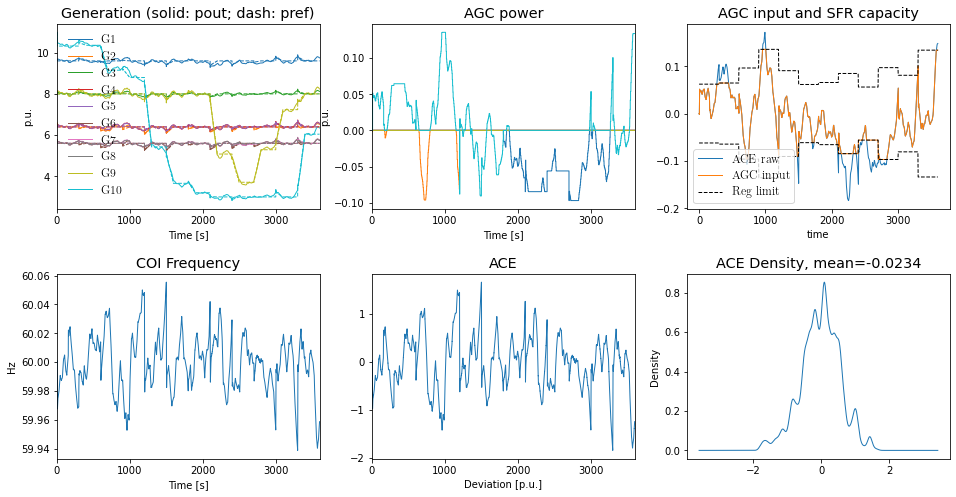

In [21]:
# color=['tab:blue', 'tab:orange', 'tab:green',
#        'tab:red', 'tab:purple']
right=end_time

fig_gen, ax_gen = plt.subplots(2, 3, figsize=(16, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)

yheader = [f'G{i}' for i in range(1,11)]

ssa.TDS.plt.plot(ssa.TGOV1N.pout,
                 linestyles=['-'],
                   yheader=yheader,
                   legend=True, show=False, right=right,
                   title=r'Generation (solid: pout; dash: pref)',
                   ylabel='p.u.',
                   fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.pref,
                 legend=False, show=False, right=right,
                   linestyles=['--'],
                   fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.paux,
                linestyles=['-'],
                yheader=yheader,
                legend=False, show=False, right=right,
                title=r'AGC power',
                ylabel='p.u.',
                fig=fig_gen, ax=ax_gen[0, 1])

ace_res.plot(linewidth=1,
            fig=fig_gen, ax=ax_gen[0, 2],
            x='time', y='ace',
            title=f'AGC input and SFR capacity')
ace_res.plot(linewidth=1,
            fig=fig_gen, ax=ax_gen[0, 2],
            x='time', y='in',)
ace_res.plot(linewidth=1, color='k', linestyle='--',
            fig=fig_gen, ax=ax_gen[0, 2],
            x='time', y='up')
ace_res.plot(linewidth=1, color='k', linestyle='--',
            fig=fig_gen, ax=ax_gen[0, 2],
            x='time', y='dn')
ax_gen[0, 2].legend(['ACE raw', 'AGC input', 'Reg limit'])

ssa.TDS.plt.plot(ssa.COI.omega,
                 legend=False, show=False, right=right,
                 linestyles=['-'],
                 ytimes=60,
                 title=r'COI Frequency',
                 ylabel='Hz',
                 fig=fig_gen, ax=ax_gen[1, 0])

ssa.TDS.plt.plot(ssa.ACEc.ace,
                 legend=False, show=False, right=right,
                 linestyles=['-'],
                 title=r'ACE',
                 ylabel='p.u.',
                 fig=fig_gen, ax=ax_gen[1, 1])

font = {'family' : 'TimesNewRoma',
        'weight' : '1',
        'size'   : 12}

plt.rc('font', **font)

ace_tds = ssa.dae.ts.y[:, ssa.ACEc.ace.a].reshape(-1).copy()
ace_df = pd.DataFrame()
ace_df['ace'] = ace_tds
ace_df.plot(kind='kde', legend=False, linewidth=1,
            fig=fig_gen, ax=ax_gen[1, 2],
            title=f'ACE Density, mean={ace_df.ace.mean().round(4)}')
ax_gen[1, 1].set(xlabel='Deviation [p.u.]', ylabel='')